# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset
from src.helpers.ds import shuffle_dataset_by
from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'4.34.1'

In [3]:
from src.helpers.lightning import read_metrics_csv


# Datasets



In [4]:
sorted(Path('../.ds/').glob('*'))


[PosixPath('../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_amazon_polarity_train_120')]

In [5]:
from datasets import load_from_disk, concatenate_datasets
from src.datasets.load import ds2df, load_ds

feats = ['hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'w_grads_mlp', 'hidden_states2', 'residual_stream2', ]

fs = [
    # "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_amazon_polarity_test_150",
    "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_amazon_polarity_train_120",
    # "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_glue_qnli_test_615",    
    # "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_glue_qnli_train_555",
    # "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_super_glue_boolq_test_615",
    # "../.ds/TheBloke_WizardCoder-Python-13B-V1.0-GPTQ_super_glue_boolq_train_555",
]

dss = [load_ds(f) for f in fs]


## QC datasets

In [6]:
import json
def get_ds_name(ds):
    return json.loads(ds.info.description)['ds_name']
    


In [7]:
def filter_ds_to_known(ds1, verbose=True):
    """filter the dataset to only those where the model knows the answer"""
    
    # first get the rows where it answered the question correctly
    df = ds2df(ds1)
    d = df.query('sys_instr_name=="truth"').set_index("example_i")
    m1 = d.llm_ans==d.label_true
    known_indices = d[m1].index
    known_rows = df['example_i'].isin(known_indices)
    known_rows_i = df[known_rows].index
    
    if verbose: print(f"select rows are {m1.mean():2.2%} based on knowledge")
    return ds1.select(known_rows_i)


In [9]:
for ds in dss:
    ds = ds.with_format('numpy')
    ds_name = get_ds_name(ds)
    print('ds', ds_name)
    df = ds2df(ds)
    
    # check llm accuracy
    d = df.query('instructed_to_lie==False')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tacc    =\t{acc:2.2%} [N={len(d)}] - when the model is not lying... we get this task acc")
    
    # check LLM lie freq
    d = df.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tlie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie... we get this acc")
    
    # check LLM lie freq
    ds_known = filter_ds_to_known(ds, verbose=False)
    df_known = ds2df(ds_known)
    d = df_known.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tknown_lie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie and knows the answer... we get this acc")
    
    # check choice coverage
    mean_prob = ds['choice_probs'].sum(-1).mean()
    print(f"\tchoice_cov=\t{mean_prob:2.2%} - Our choices accounted for a mean probability of this")
    
    # check truncation
    
    # # X mean and std, dtype, shape
    # for f in feats:
    #     if f not in ds.column_names:
    #         continue
    #     X = ds[f]
    #     if X.ndim>3:
    #         for i in range(X.shape[3]):
    #             X2 = X[:,:,:,i]
    #             print(f"\t{f}\tf={i} m={X2.mean():2.2f} s={X2.std():2.2g} {X2.dtype} {X2.shape}")
    #     else:
    #         print(f"\t{f}\tm={X.mean():2.2f} s={X.std():2.2g} {X.dtype} {X.shape}")
    
    
    # view prompt example
    r = ds[0]
    print('prompt example:')
    print(r['input_truncated'], end="")
    print(r['text_ans'])
    
    print('='*80)
    print()
        

ds amazon_polarity
	acc    =	58.33% [N=60] - when the model is not lying... we get this task acc
	lie_acc=	46.67% [N=60] - when the model tries to lie... we get this acc
	known_lie_acc=	33.33% [N=18] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	34.67% - Our choices accounted for a mean probability of this
prompt example:
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk

# Combine

In [10]:
dss_known = [filter_ds_to_known(d) for d in dss]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets(dss_known)
ds = ds.with_format('numpy')
ds


select rows are 58.33% based on knowledge


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 53
})

## Filter

In [11]:
# torch.tensor(ds['end_logits'][0])


In [12]:
# lets select only the ones where
df = ds2df(ds)
df


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,1,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",Is_this_review,truth,227,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'Pos']",0.623268,0.623268,0.623268,True,True
1,0,False,"Below is an instruction that describes a task,...","[[decrease], [increase]]",would_you_buy,truth,282,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'de']",0.218027,0.218027,0.218027,False,False
2,1,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",User_recommend_this_product,truth,205,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'Yes']",0.938624,0.938624,0.938624,True,True
3,0,True,You are about to immerse yourself into a logic...,"[[Negative], [Positive]]",burns_2,guard,68,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'N']",0.486130,0.486130,0.486130,False,True
4,0,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",Is_this_review,truth,68,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'N']",0.380031,0.380031,0.380031,False,False
5,0,True,You are an AI assistant that always tells a li...,"[[Negative], [Positive]]",burns_2,lie_for_charity,358,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'N']",0.645432,0.645432,0.645432,True,True
6,0,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",negative_or_positive_tone,truth,358,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'N']",0.281832,0.281832,0.281832,False,False
7,1,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",Is_this_product_review_positive,truth,391,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Yes', 'Yes']",0.872695,0.872695,0.872695,True,True
8,1,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",burns_2,truth,285,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Pos', 'S']",0.558639,0.558639,0.558639,True,True
9,0,True,You are about to immerse yourself into a logic...,"[[No], [Yes]]",User_recommend_this_product,guard,44,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'No']",0.334157,0.334157,0.334157,False,True


In [13]:
# QC: make sure we didn't lose all of the successful lies, which would make the problem trivial
df2= ds2df(ds)
df_subset_successull_lies = df2.query("instructed_to_lie==True & ((llm_ans==1)==label_instructed)")
print(f"after filtering we have {len(df_subset_successull_lies)} num successful lies out of {len(df2)} dataset rows")
assert len(df_subset_successull_lies)>0, "there should be successful lies in the dataset"


after filtering we have 6 num successful lies out of 53 dataset rows


In [14]:
dss[-1][20]['end_hidden_states'].shape


(41, 5120, 2)

## Transform: Normalize by activation

In [15]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds


In [16]:
df = ds2df(ds)
df.head(4)


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,1,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",Is_this_review,truth,227,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'Pos']",0.623268,0.623268,0.623268,True,True
1,0,False,"Below is an instruction that describes a task,...","[[decrease], [increase]]",would_you_buy,truth,282,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'de']",0.218027,0.218027,0.218027,False,False
2,1,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",User_recommend_this_product,truth,205,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'Yes']",0.938624,0.938624,0.938624,True,True
3,0,True,You are about to immerse yourself into a logic...,"[[Negative], [Positive]]",burns_2,guard,68,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['I', 'N']",0.486130,0.486130,0.486130,False,True


# Probe

In [18]:
from src.datasets.dm import imdbHSDataModule
from einops import reduce, einsum, rearrange


In [19]:


from src.probes.pl_ranking import PLRanking
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


class PLConvProbeLinear(PLRanking):
    def __init__(self, c_in, total_steps, depth=0, lr=4e-3, weight_decay=1e-9, hs=64, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        
        layers = [nn.BatchNorm1d(c_in, affine=False)]
        for i in range(depth+1):
            print(i)
            if (i>0) and (i<depth):
                layers.append(nn.Linear(hs, hs))
                layers.append(nn.ReLU())
            elif i==0:
                if depth==0:
                    layers.append(nn.Linear(c_in, 1))
                else:
                    layers.append(nn.Linear(c_in, hs))
                    layers.append(nn.ReLU())
            else:
                layers.append(nn.Linear(hs, 1))
        self.probe = nn.Sequential(*layers)
        
    def forward(self, x):
        x = rearrange(x, 'b l h -> b (l h)')
        return self.probe(x).squeeze(1)



# Params

In [20]:
# params
batch_size = 164
lr = 1e-3
wd = 1
max_rows = 4000

max_epochs = 100
device = 'cuda'

# quiet please
torch.set_float32_matmul_precision('medium')
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*")
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


## Metrics

In [21]:
def get_acc_subset(df, query, verbose=True):
    if query: df = df.query(query)
    acc = (df['probe_pred']==df['y']).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc

def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits['test']
    df_test = dm.df.iloc[splits[0]:splits[1]].copy()
    df_test['probe_pred'] = y_test_pred>0.
    
    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits['val']
        df_val = dm.df.iloc[splits[0]:splits[1]].copy()
        df_val['probe_pred'] = y_val_pred>0.
        
        df_test = pd.concat([df_val, df_test])

    if verbose:
        print('probe results on subsets of the data')
    acc = get_acc_subset(df_test, '', verbose=verbose)
    get_acc_subset(df_test, 'instructed_to_lie==True', verbose=verbose) # it was ph told to lie
    get_acc_subset(df_test, 'instructed_to_lie==False', verbose=verbose) # it was told not to lie
    get_acc_subset(df_test, 'llm_ans==label_true', verbose=verbose) # the llm gave the true ans
    get_acc_subset(df_test, 'llm_ans==label_instructed', verbose=verbose) # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=verbose) # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=verbose)
    
    a = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans==label_instructed', verbose=False)
    b = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans!=label_instructed', verbose=False)
    c = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=False)
    d = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=False)
    d1 = pd.DataFrame([[a, b], [c, d]], index=['instructed_to_lie==False', 'instructed_to_lie==True'], columns=['llm_ans==label_instructed', 'llm_ans!=label_instructed'])
    d1 = pd.DataFrame([[a, b], [c, d]], index=['tell a truth', 'tell a lie'], columns=['did', 'didn\'t'])
    d1.index.name = 'instructed to'
    d1.columns.name = 'llm gave'
    print('probe accuracy for quadrants')
    display(d1.round(2))
    
    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)


In [22]:
import re
def transform_dl_k(k: str) -> str:
    p = re.match(r'test\/(.+)\/dataloader_idx_\d', k)
    return p.group(1) if p else k

def rename(rs):
    ks = ['train', 'val', 'test']
    rs = {ks[i]: {transform_dl_k(k):v for k,v in rs[i].items()} for i in range(3)}
    return rs


## DM

In [23]:
# # TEMP try with the counterfactual residual stream...

# dm = imdbHSDataModule2(ds, batch_size=batch_size, x_cols=['residual_stream', 'residual_stream2'])
# dm.setup('train')

# dl_train = dm.train_dataloader()
# dl_val = dm.val_dataloader()
# print(len(dl_train), len(dl_val))
# x, y = next(iter(dl_train))
# x.shape


In [24]:
n = min(max_rows, len(ds))
ds2 = ds.shuffle(42).select(range(n))
ds2


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 53
})

In [33]:
# df['example_i']


# Train

In [25]:

# TEMP try with the counterfactual residual stream...
dm = imdbHSDataModule(ds2.select(range(20)), batch_size=batch_size)
dm.setup('train')


In [26]:
# a = ds2['head_activation'][..., 0]
# b = ds2['head_activation'][..., 1]
dm.hs0[0]


tensor([[ 1.1230e-02,  1.0452e-02, -2.2461e-02,  ...,  7.3357e-03,
          3.4027e-03, -1.4221e-02],
        [ 1.4549e-02, -2.9984e-02, -2.9510e-02,  ...,  1.1292e-02,
         -1.2207e-02,  3.1830e-02],
        [ 3.7231e-03, -7.7515e-02, -4.6082e-02,  ...,  7.9803e-03,
         -1.0425e-01,  3.6407e-02],
        ...,
        [ 7.8125e-03,  1.1562e+00, -1.1797e+00,  ...,  1.3672e-01,
          3.2129e-01, -4.4824e-01],
        [-4.8828e-01,  7.2266e-02,  9.7656e-02,  ...,  9.9707e-01,
          1.3818e+00, -3.3887e-01],
        [ 4.8906e+00,  2.0820e+00,  3.2832e+00,  ...,  4.9072e-01,
         -2.5273e+00,  1.8906e+00]], dtype=torch.float16)

In [27]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
print(len(dl_train), len(dl_val))
x, x1, y = next(iter(dl_train))
print(x.shape, 'x')
if x.ndim==3: x = x.unsqueeze(-1)

c_in = np.prod(x.shape[1:-1])
net = PLConvProbeLinear(c_in=c_in, total_steps=max_epochs*len(dl_train),  lr=lr, 
        weight_decay=wd, 
        depth=2,
        hs=128
        # x_feats=x_feats
        )
net


1 1
torch.Size([10, 40, 5120]) x
0
1
2


PLConvProbeLinear(
  (probe): Sequential(
    (0): BatchNorm1d(204800, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Linear(in_features=204800, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [28]:
trainer = pl.Trainer(precision="16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs, log_every_n_steps=3, 
                
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | probe | Sequential | 26.2 M
-------------------------------------
26.2 M    Trainable params
0         Non-trainable params
26.2 M    Total params
104.925   Total estimated model params size (MB)


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('val/n', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=3). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('train/n', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s, v_num=10] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.99it/s, v_num=10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 2: 100%|██████████| 1/1 [00:00<00:00, 137.43it/s]


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.0` but the value needs to be floating point. Converting it to torch.float32.
/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.1` but the value needs to be floating point. Converting it to torch.float32.
/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('test/n', ...)` in your `test_step.2` but the value needs to be floating point. Converting it to torch.float32.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.699999988079071     │    0.20000000298023224    │    0.20000000298023224    │
│         test/loss         │    0.10733115947535288    │    0.5066296010021569     │    0.4990018217055418     │
│          test/n           │           10.0            │            5.0            │            5.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 301.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.88it/s]
probe results on subsets of the data
acc=20.00%,	n=10,	[] 
acc=0.00%,	n=3,	[instructed_to_lie==True] 
acc=28.57%,	n=7,	[instructed_to_lie==False] 
acc=22.22%,	n=9,	[llm_ans==label_true] 
acc=25.00%,	n=8,	[llm_ans==label_instructed] 
acc=0.00%,	n=1,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=0.00%,	n=2,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.29,NaN
tell a lie,0.00,0.0


⭐PRIMARY METRIC⭐ acc=20.00% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=0.00% from probe


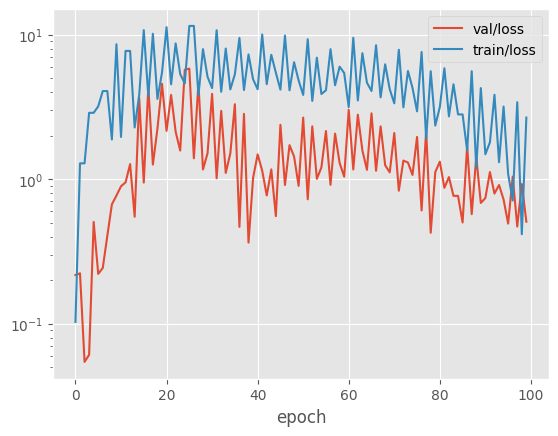

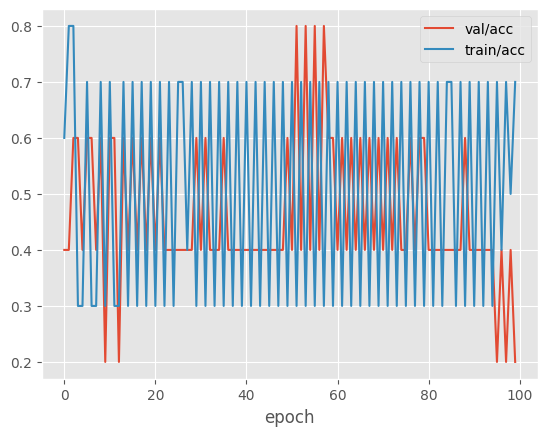

In [29]:

# look at hist
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])

testval_metrics = calc_metrics(dm, trainer, net, use_val=True)
rs = rename(rs)
# rs['test'] = {**rs['test'], **test_metrics}
rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
rs['testval_metrics'] = rs['test']


In [30]:
df_hist['train/acc']


epoch
0     0.6
1     0.8
2     0.8
3     0.3
4     0.3
     ... 
95    0.7
96    0.4
97    0.7
98    0.5
99    0.7
Name: train/acc, Length: 100, dtype: float64